# photometry_test_G.ipynb

Visitごとに、セレクトされたデータを用いて開口測光を行い、スポットの位置(緯度・経度)や明るさ(EFPの明るさとバックグラウンド)を測定し保存する。

Ganymedeフットプリント用

In [277]:
import numpy as np
import math
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from numba import njit

import spiceypy as spice
import hstprojimage as hst
from TScmap import TScmap
import ftpS3

In [278]:
spice.furnsh('kernel/cassMetaK.txt')

# 北半球
filename = 'data/red/2022/349_v24/jup_22-349-05-54-53_0030_v24_stis_f25srf2_flatproj.fits'
ext = 0
hext = 1
with fits.open(filename) as hdul:
    image = hdul[ext].data # .astype(np.float32)
    h = hdul[hext].header

# HST data
moon = 'GANYMEDE'
h = hst.HSTProjImage(filename)
h.readHSTFile()
h.MOON = moon
IMG = h.image
hem = h.alm.hemisph
print('hem', hem)

OBS DATE 2022-12-15T05:54:53
hem north


(1000, 1000)


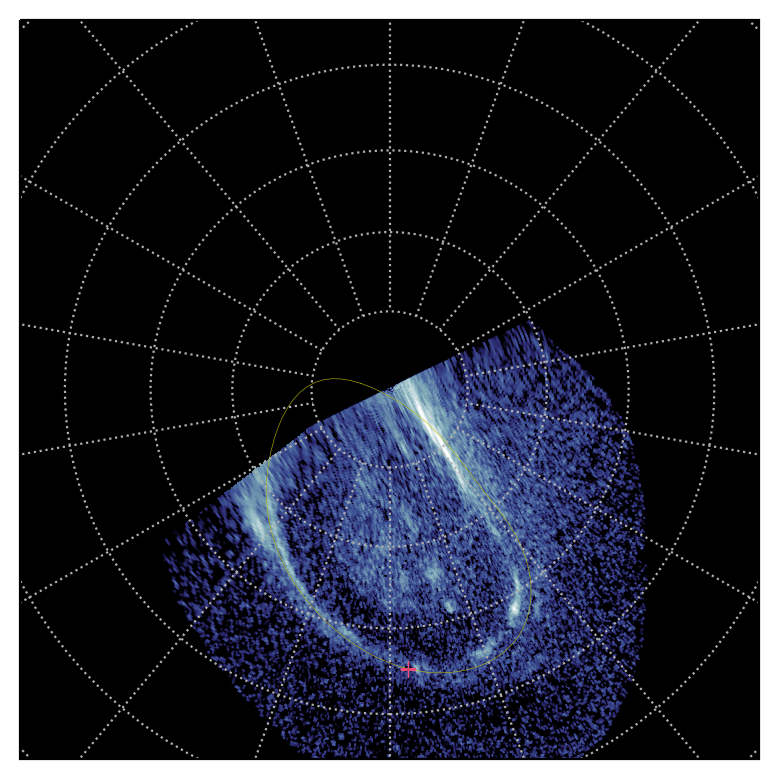

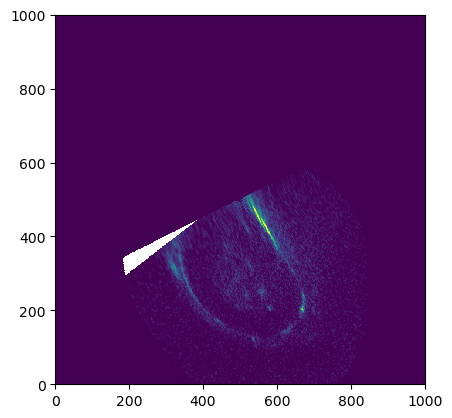

In [279]:
extdeg = 45.0
fig, ax = plt.subplots(dpi=200)
ax, dimage, gl = h.tvPolar(ax, vmin=10, vmax=2000,
                  draw_labels=False, refmainoval=False,
                  satovals=['ga'],
                  reflon=None,
                  # reflon=h.alm.cml,
                  ext=extdeg,
                  )

print(dimage.shape)
Npx = dimage.shape[0]
dimage = dimage[:,::-1]
if hem == 'south':
    dimage = dimage[:,::-1]
fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.pcolormesh(dimage)
plt.show()

In [280]:
# Location of the selected moon's footprint
# Footprint予測位置と、footprint軌跡の向きを知りたい
refnum = 0
if hem == 'south':
    refnum = 1
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
s3moon, s3wlon_lin, s3lat_lin, s3wlon00, s3lat00 = ftpS3.ftpS3().FP(h.datetime, satoval, 'GANYMEDE')
print(s3wlon00, s3lat00)

176.52 55.2


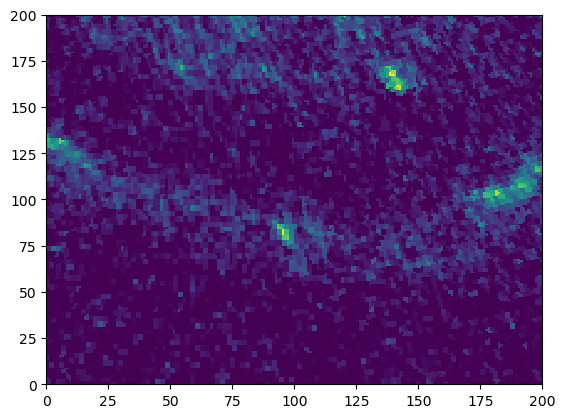

In [281]:
x0, x1 = 440, 640
y0, y1 = 40, 240
img = dimage[y0:y1,x0:x1]
fig, ax = plt.subplots(dpi=100)
ax.pcolormesh(img)
plt.show()

開口測光 (Aperture Photometry)

In [282]:
# Find bright spots
mean = np.average(img)
median = np.median(img)
std = np.std(img)
print('STD', std)
thres = 1.2*std
daofind = DAOStarFinder(fwhm=8.0, threshold=thres)  
# https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html
# DAOStarFinderのfluxの定義 ... stdのfactor倍
sources = daofind(img)  
print(sources)

STD 82.06992
 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  45.20354396936809 ...  2.909553050994873  -1.1595657006480158
  2   139.506507474148 ... 1.6265877485275269  -0.5281937421669807
  3 154.07075229607034 ... 1.9294229745864868  -0.7135686139415536
  4  70.53874239176594 ... 3.0359835624694824  -1.2057485396428254
  5 14.406430288361646 ...  1.179294466972351 -0.17905565229143522
  6 197.08509894918663 ... 1.3769505023956299 -0.34729582209689963
  7 129.13322960172488 ...  1.278015375137329 -0.26634019656130276
  8  48.91466658520099 ...  2.970808267593384   -1.182186559656285
  9    89.609104669245 ...  2.687248468399048  -1.0732695600778632
 10 117.97577684257688 ... 1.3350045680999756 -0.31370687941481457
...                ... ...                ...                  ...
187 170.71588405377008 ...  4.109853267669678  -1.5345657918076083
188 15.290975067118632 ...  5.739653587341309   -

=== JRM33 Estimation ===
Sys3,lat 176.26696584068796 55.15556473299886
Wlong [deg] 176.26696584068796
Lat [deg] 55.15556473299886
extdeg 45.0
ftps3lat 55.15556473299886
=== The spot ===
Nearest [px]: 77 [522.02471472 130.32117643]
Number of pixels [px]:  121
Brightness peak [kR]:  211.00340270996094
Brightness flux [kR]:  456.1975584427302
Wlong [deg] 176.59046391116237
Lat [deg] 55.88849576082432
    final_phot   
-----------------
4575.041971088327


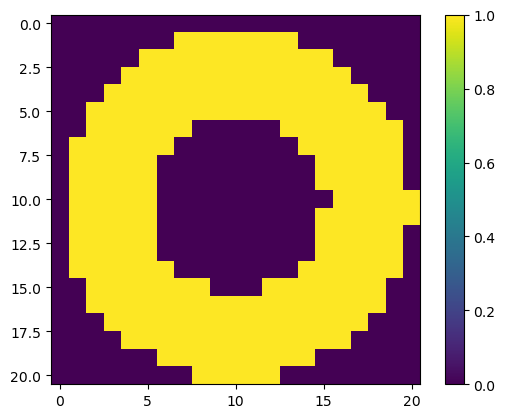

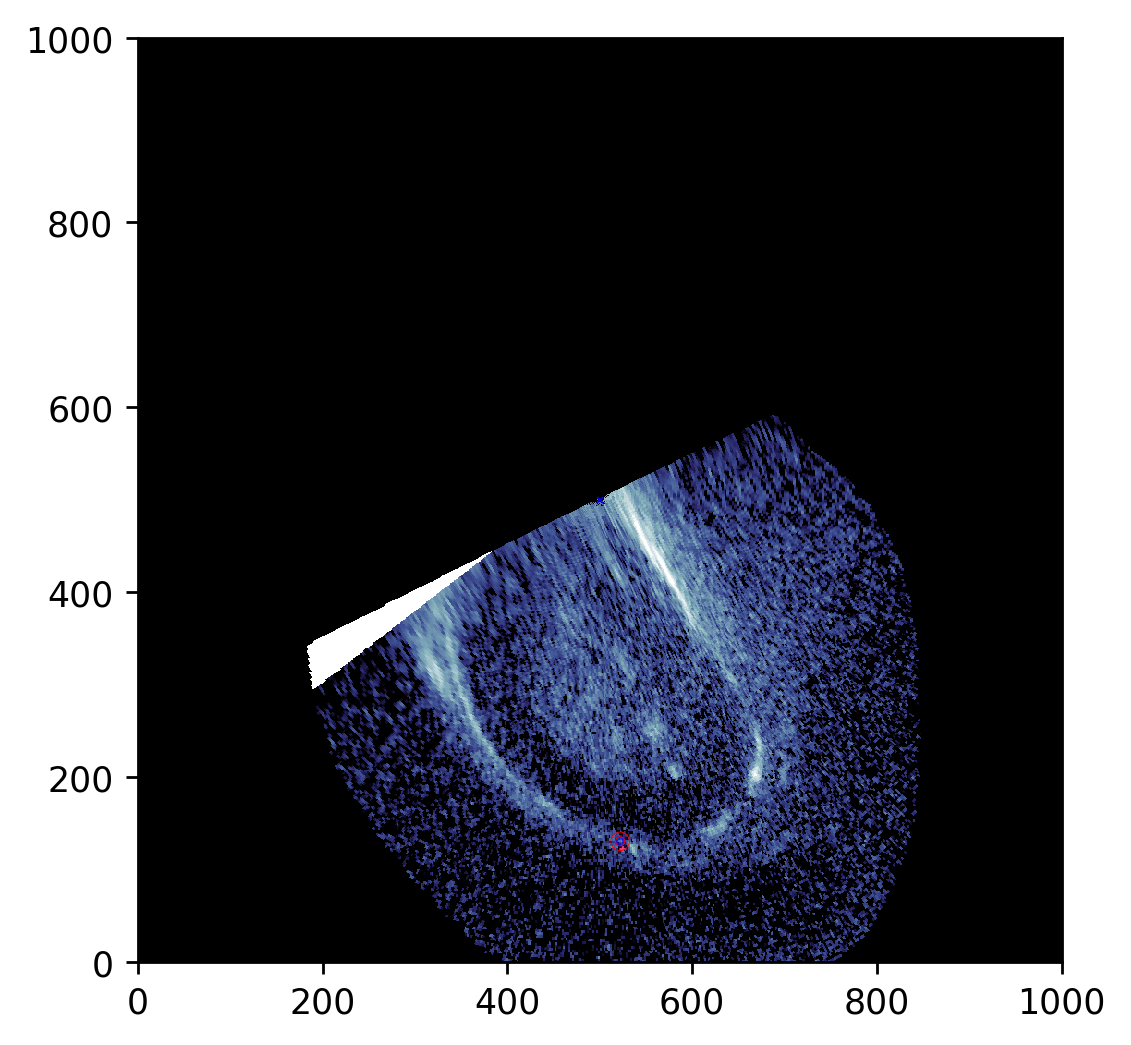

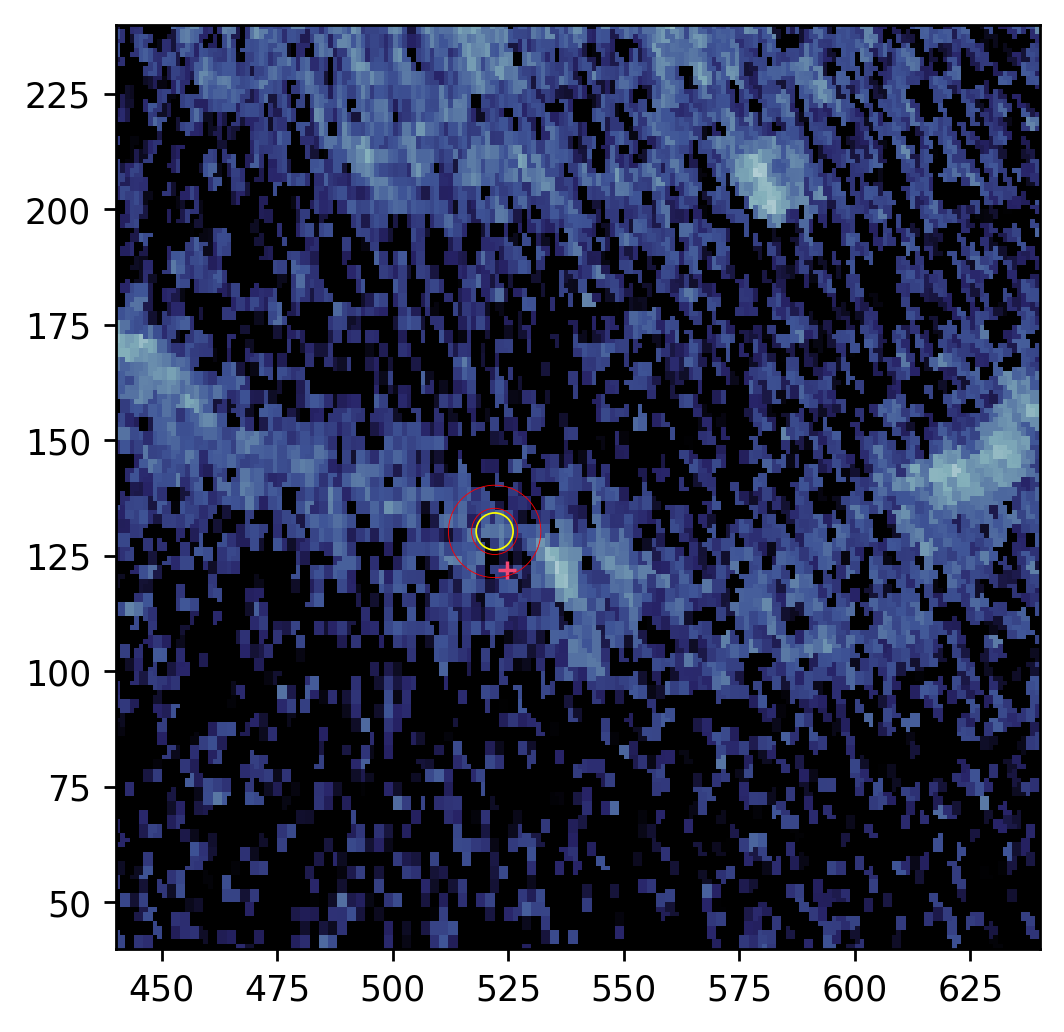

In [283]:
ftps3wlon = h.s3wlon_lin            # [deg]
ftps3lat = h.s3lat_lin              # [deg]
print('=== JRM33 Estimation ===')
print('Sys3,lat', ftps3wlon, ftps3lat)
print('Wlong [deg]', ftps3wlon)
print('Lat [deg]', ftps3lat)
if hem=='south':
    ftps3lat *= -1

ftpelon = 360-(ftps3wlon-90)        # [deg]
ftpcolat = 90-ftps3lat              # [deg]
ftpR = ftpcolat*(Npx/(2*extdeg))    # [px]
ftpR = (Npx/2)*(math.tan(math.radians(ftpcolat/2))/math.tan(math.radians((90-extdeg)/2)))     # [px]
print('extdeg', extdeg)
print('ftps3lat', ftps3lat)
ftpX = ftpR*np.cos(np.radians(ftpelon))         # [px]
ftpY = ftpR*np.sin(np.radians(ftpelon))         # [px]
ftpX += Npx/2
ftpY += Npx/2
# print(ftpcolat, ftpR, ftpX, ftpY)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  # [px]
positions[:,0] += x0    # [px]
positions[:,1] += y0    # [px]

posarg0 = np.argmin(np.absolute((positions[:,0]-ftpX)**2 + (positions[:,1]-ftpY)**2))
print('=== The spot ===')
print('Nearest [px]:', posarg0, positions[posarg0,:])
print('Number of pixels [px]: ', sources['npix'][posarg0])
print('Brightness peak [kR]: ', sources['peak'][posarg0])
print('Brightness flux [kR]: ', sources['flux'][posarg0]*thres)

posX = positions[posarg0,0]-Npx/2
posY = positions[posarg0,1]-Npx/2
posR = math.sqrt(posX**2 + posY**2)             # [px]
poslat = posR*(2*extdeg/Npx)
poslat = math.degrees(2*math.atan2(posR*math.tan(0.5*math.radians(90-extdeg)), Npx/2))
postheta = math.atan2(posY,posX)-0.5*np.pi
# print('theta [deg]', math.degrees(postheta))
print('Wlong [deg]', -math.degrees(postheta))
print('Lat [deg]', 90-poslat)

# Aperture photometry
apertures = CircularAperture(positions[posarg0,:], r=4.)
rawflux = aperture_photometry(dimage, apertures)
# print(rawflux)

# 局所的な背景を測定する
# 各スポットを中心とした輪っかを作成
annulus_apertures = CircularAnnulus(positions[posarg0,:], r_in=5., r_out=10.)

# sigmaクリッピング法を用いる
# http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
annulus_masks = annulus_apertures.to_mask(method='center')
annulus_data = annulus_masks.multiply(dimage)
annulus_data_1d = annulus_data[annulus_masks.data > 0]
_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
bkg_median = median_sigclip
rawflux['annulus_median'] = bkg_median
rawflux['aper_bkg'] = bkg_median*apertures.area
rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
print(rawflux['final_phot'])
plt.imshow(annulus_masks)
plt.colorbar()
plt.show()




# Plots
fig, ax = plt.subplots(dpi=250)
ax.set_aspect('equal')
# ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(), vmin=median-5*std, vmax=median+5*std, zorder=0.1)
ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.plot(ftpX, ftpY,
        markersize=2, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=0.5, zorder=1)
ax.plot(Npx/2, Npx/2,
        markersize=2, marker='x', markerfacecolor='blue',
        markeredgecolor='blue', markeredgewidth=0.5, zorder=1)
apertures.plot(color='blue', lw=1.0, alpha=0.6)
annulus_apertures.plot(color='red', lw=0.25)
plt.show()

fig, ax = plt.subplots(dpi=250)
ax.set_aspect('equal')
ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)
# ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(), vmin=median-5*std, vmax=median+5*std, zorder=0.1)
ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.plot(ftpX, ftpY,
        markersize=5, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=1, zorder=1)
ax.plot(Npx/2, Npx/2,
        markersize=2, marker='x', markerfacecolor='blue',
        markeredgecolor='blue', markeredgewidth=0.5, zorder=1)
apertures.plot(color='yellow', lw=0.5, alpha=1.0)
annulus_apertures.plot(color='red', lw=0.25, alpha=1.0)
plt.show()

 id      xcenter           ycenter       ...     final_phot      final_phot_ave 
           pix               pix         ...                                    
--- ----------------- ------------------ ... ----------------- -----------------
  1 522.0247147217294 130.32117642985992 ... 4575.041971088327 91.01756806894943
   aperture_sum  
-----------------
7882.654680884604
  annulus_median 
-----------------
65.80286407470703
     aper_bkg    
-----------------
3307.612709796277
  final_phot_ave 
-----------------
91.01756806894943


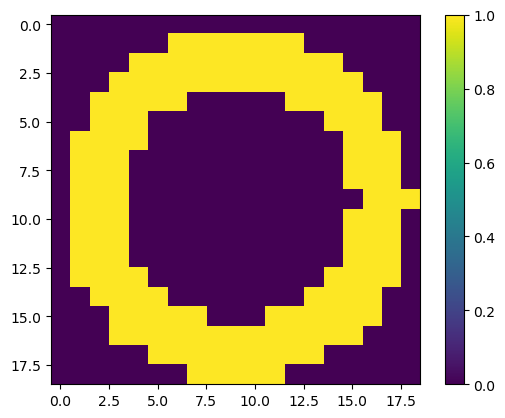

In [284]:
# Aperture photometry
apertures = CircularAperture(positions[posarg0,:], r=4.)
rawflux = aperture_photometry(dimage, apertures)
# print(rawflux)

# 局所的な背景を測定する
# 各スポットを中心とした輪っかを作成
annulus_apertures = CircularAnnulus(positions[posarg0,:], r_in=6., r_out=9.)

# sigmaクリッピング法を用いる
# http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
# ここではガウシアン開口ではなくただの円開口を用いる
# rawfluxには開口内の合計カウント値が入っているので、バックグラウンドとして`bkg_median*apertures.area`
# を作成し、`rawflux['aperture_sum']`からさっ引く。
annulus_masks = annulus_apertures.to_mask(method='center')
annulus_data = annulus_masks.multiply(dimage)
annulus_data_1d = annulus_data[annulus_masks.data > 0]  # 輪っか内部の値だけ抽出
_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
bkg_median = median_sigclip
rawflux['annulus_median'] = bkg_median
rawflux['aper_bkg'] = bkg_median*apertures.area
rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
rawflux['final_phot_ave'] = rawflux['final_phot']/apertures.area
print(rawflux)
print(rawflux['aperture_sum'])
print(rawflux['annulus_median'])
print(rawflux['aper_bkg'])
print(rawflux['final_phot_ave'])
plt.imshow(annulus_masks)
plt.colorbar()
plt.show()

In [285]:
def Aperture(IMAGE, POSITION):
    """_summary_

    Args:
        IMAGE (2d ndarray): raw image
        POSITION (1d array): position of one spot in the raw image

    Returns:
        apertures (CircularAperture): \n
        rawflux (QTable): QTable including the spot position and the final photometry averaged in pixels. \n
            `['id']` \n
            `['xcenter']` : x position [px] \n
            `['ycenter']` : y position [px] \n
            `['aperture_sum']` : summation of brightness in the target aperture
            `['annulus_median']` : the median inside the donut \n
            `['aper_bkg']` : summation of the median inside the donut \n
            `['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']` \n
            `['final_phot_ave'] = rawflux['final_phot']/apertures.area`
            
    """
    # Aperture photometry
    apertures = CircularAperture(POSITION, r=8.)
    rawflux = aperture_photometry(IMAGE, apertures)

    # Make a donut to calculate the local background in.
    annulus_apertures = CircularAnnulus(POSITION, r_in=10.0, r_out=13.)

    # Sigma-clipping
    # http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
    annulus_masks = annulus_apertures.to_mask(method='center')

    # Mask inside the donut
    annulus_data = annulus_masks.multiply(IMAGE)
    annulus_data_1d = annulus_data[annulus_masks.data > 0]  # 輪っか内部の値だけ抽出

    # Calculate the median as the local background
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median = median_sigclip*1.0

    # Add results to the rawflux data
    rawflux['annulus_median'] = bkg_median
    rawflux['aper_bkg'] = bkg_median*apertures.area
    rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
    rawflux['final_phot_ave'] = rawflux['final_phot']/apertures.area
    
    return apertures, rawflux


 id      xcenter      ...     final_phot       final_phot_ave  
           pix        ...                                      
--- ----------------- ... ------------------ ------------------
  1 522.0247147217294 ... 2653.6251105830634 13.198048545689748
   aperture_sum   
------------------
19860.554520953392
  annulus_median 
-----------------
85.58024597167969
     aper_bkg    
-----------------
17206.92941037033
  final_phot_ave  
------------------
13.198048545689748


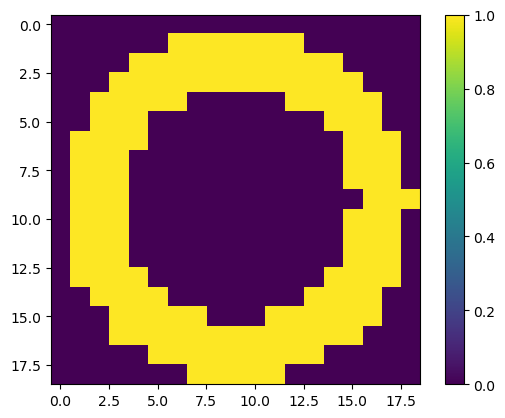

In [286]:
# Aperture photometry
aperture, rawflux = Aperture(dimage, positions[posarg0,:])
print(rawflux)
print(rawflux['aperture_sum'])
print(rawflux['annulus_median'])
print(rawflux['aper_bkg'])
print(rawflux['final_phot_ave'])
plt.imshow(annulus_masks)
plt.colorbar()
plt.show()

In [287]:
def lat_wlong2px(lat, wlong, N0px, extdeg, hem):
    """_summary_

    Args:
        lat (float): latitude of the point [deg]
        wlong (float): west longitude of the point [deg]
        N0px (int): number of pixels in an axis [px]
        extdeg (float): extent of the image [deg]

    Returns:
        X: X position [px]
        Y: Y position [px]
    """
    if hem=='south':
        lat = lat * (-1)

    elon = 360-(wlong-90)        # [deg]
    colat = 90-lat               # [deg]
    R = (N0px/2)*(np.tan(np.radians(colat/2))/np.tan(np.radians((90-extdeg)/2)))     # [px]
    X = R*np.cos(np.radians(elon))         # [px]
    Y = R*np.sin(np.radians(elon))         # [px]
    X += N0px/2
    Y += N0px/2
    return X, Y

In [288]:
def px2lat_wlong(X, Y, N0px, extdeg, hem):
    """_summary_

    Args:
        X (float): X position(s) [px]
        Y (float): Y position(s) [px]
        N0px (int): number of pixels in an axis [px]
        extdeg (float): extent of the image [deg]

    Returns:
        lat: latitude [deg]
        wlong: west longitude [deg]
    """
    posX = X-N0px/2
    posY = Y-N0px/2

    posR = np.sqrt(posX**2 + posY**2)
    poscolat = np.degrees(2*np.arctan2(posR*np.tan(0.5*np.radians(90-extdeg)), N0px/2))
    postheta = np.arctan2(posY,posX)-0.5*np.pi

    wlong = -np.degrees(postheta)
    lat =  90-poscolat

    if hem=='south':
        lat = lat*(-1)

    return lat, wlong

1st 524.6626769626288 122.00526958604661
2nd 522.9619049311145 122.41320323354006
vmodel [-1.70077203  0.40793365]


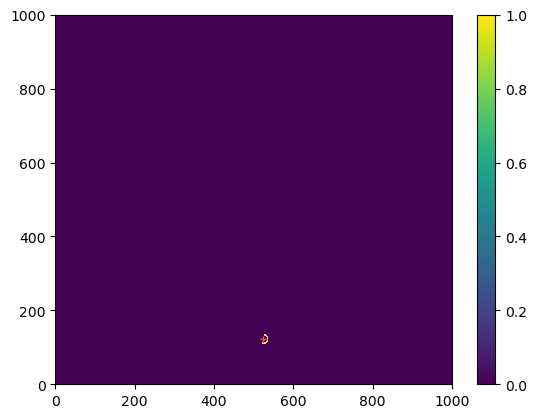

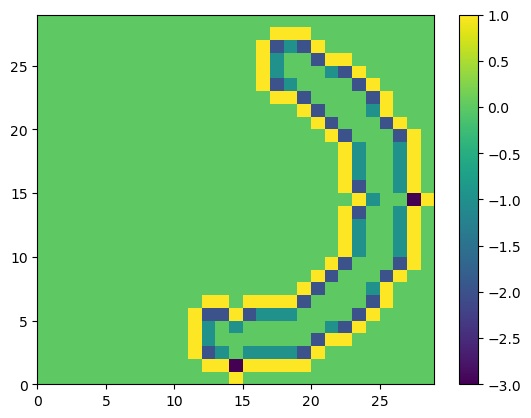

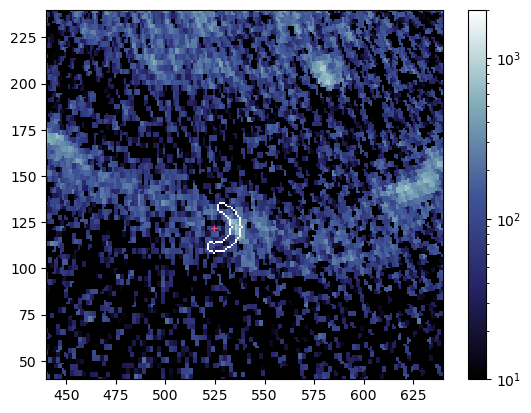

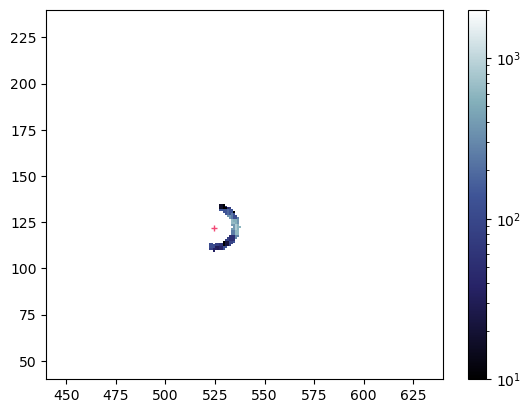

110.81861877441406


In [289]:
# 半リングを作る
ftpX, ftpY = lat_wlong2px(s3lat_lin, s3wlon_lin, Npx, extdeg, hem)  # footprint best fit
ftpX0, ftpY0 = lat_wlong2px(s3lat00, s3wlon00, Npx, extdeg, hem)      # footprint 2nd best
print('1st', ftpX, ftpY)
print('2nd', ftpX0, ftpY0)


# Vector that connects the two model footprints
vmodel = np.array([ftpX0-ftpX, ftpY0-ftpY])
print('vmodel', vmodel)

# Make a mask
r_in = 9       # [px]
r_out = 13      # [px]
xgrid = np.arange(-r_out, r_out+1, 1)
ygrid = np.arange(-r_out, r_out+1, 1)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
rgrid = np.sqrt(xgrid**2 + ygrid**2)
mask_arr = np.zeros(xgrid.shape)
ring = np.where((rgrid>r_in)&(rgrid<=r_out))
mask_arr[ring] = 1


# Calculate the dot
dot = vmodel[0]*xgrid + vmodel[1]*ygrid
dotmask = np.where((mask_arr>0)&(dot<0))
mask_arr[dotmask] = 2
mask_arr[np.where(mask_arr<2)] = 0
mask_arr[np.where(mask_arr>0)] = 1


# Mask
mask = np.zeros((Npx, Npx))
mask[int(ftpY)-r_out:int(ftpY)+r_out+1, int(ftpX)-r_out:int(ftpX)+r_out+1] = mask_arr

fig, ax = plt.subplots()
# ax.set_xlim(500,700)
# ax.set_ylim(0,200)
ax.plot(ftpX, ftpY,
        markersize=5, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=1, zorder=1)
pmap = ax.pcolormesh(mask, zorder=0.5)
plt.colorbar(pmap)
plt.show()


# Mask edge
maskarrbase = np.zeros((mask_arr.shape[0]+2, mask_arr.shape[1]+2))
# maskarrbase[1:mask_arr.shape[0]+1,1:mask_arr.shape[1]+1] += mask_arr
maskarrbase[0:mask_arr.shape[0]+0,1:mask_arr.shape[1]+1] += mask_arr
maskarrbase[1:mask_arr.shape[0]+1,2:mask_arr.shape[1]+2] += mask_arr
maskarrbase[1:mask_arr.shape[0]+1,0:mask_arr.shape[1]] += mask_arr
maskarrbase[2:mask_arr.shape[0]+2,1:mask_arr.shape[1]+1] += mask_arr
maskarrbase[1:mask_arr.shape[0]+1,1:mask_arr.shape[1]+1] -= 4*mask_arr
maskarrbase[np.where(maskarrbase>0)] = 1
# maskarrbase[np.where(maskarrbase<1)] = None
maskedge = np.zeros((Npx, Npx))
maskedge[int(ftpY)-r_out-1:int(ftpY)+r_out+2, int(ftpX)-r_out-1:int(ftpX)+r_out+2] = maskarrbase
maskedge = np.ma.masked_array(maskedge, maskedge<1)

fig, ax = plt.subplots()
pmap = ax.pcolormesh(maskarrbase)
plt.colorbar(pmap)
plt.show()


# Image with mask edge
fig, ax = plt.subplots()
ax.set_xlim(440,640)
ax.set_ylim(40,240)
ax.plot(ftpX, ftpY,
        markersize=5, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=1, zorder=1)
pmap = ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.pcolormesh(maskedge, cmap='Greys', zorder=1) #, extent=[int(ftpX)-r_out-1, int(ftpX)+r_out+2, int(ftpY)+r_out+2, int(ftpY)-r_out-1], zorder=1)
plt.colorbar(pmap)
plt.show()


# Masked image
fig, ax = plt.subplots()
ax.set_xlim(440,640)
ax.set_ylim(40,240)
ax.plot(ftpX, ftpY,
        markersize=5, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=1, zorder=1)
pmap = ax.pcolormesh(mask*dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
plt.colorbar(pmap)
plt.show()


# Standard deviation
maskedimg = mask*dimage
_, median_sigclip, _ = sigma_clipped_stats(maskedimg[np.where(maskedimg>0)])
print(median_sigclip)

=== The spot ===
Nearest [px]: 77 [522.02471472 130.32117643]
Number of pixels [px]:  121
Brightness peak [kR]:  211.00340270996094
Brightness flux [kR]:  456.1975584427302
Wlong [deg] 176.59046391116237
Lat [deg] 55.88849576082432


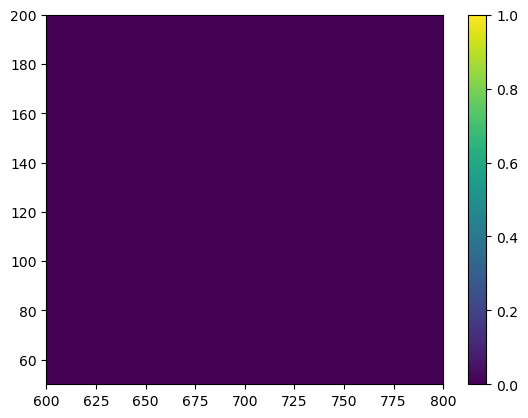

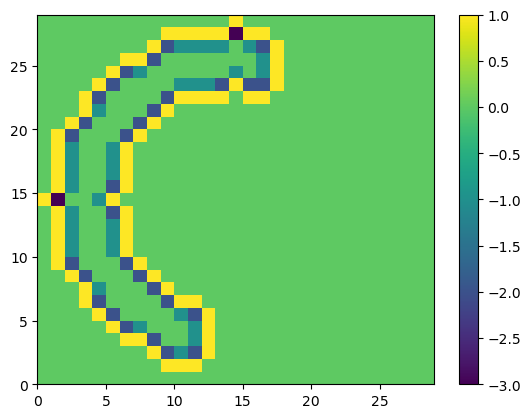

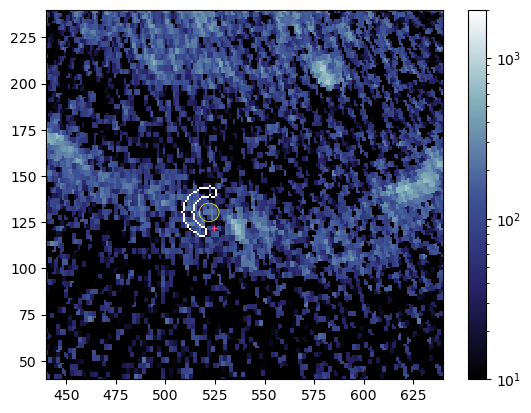

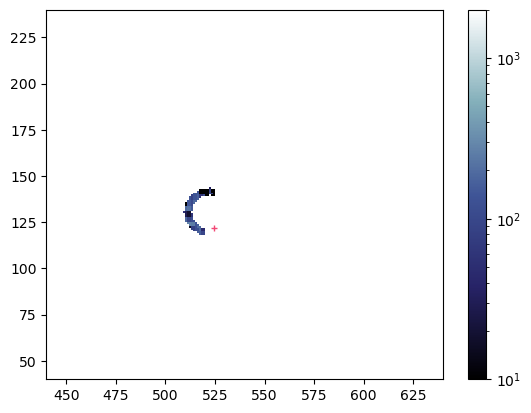

100.69551086425781


In [290]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  # [px]
positions[:,0] += x0    # [px]
positions[:,1] += y0    # [px]

posarg0 = np.argmin(np.absolute((positions[:,0]-ftpX)**2 + (positions[:,1]-ftpY)**2))
print('=== The spot ===')
print('Nearest [px]:', posarg0, positions[posarg0,:])
print('Number of pixels [px]: ', sources['npix'][posarg0])
print('Brightness peak [kR]: ', sources['peak'][posarg0])
print('Brightness flux [kR]: ', sources['flux'][posarg0]*thres)

posX = positions[posarg0,0]-Npx/2
posY = positions[posarg0,1]-Npx/2
posR = math.sqrt(posX**2 + posY**2)             # [px]
poslat = posR*(2*extdeg/Npx)
poslat = math.degrees(2*math.atan2(posR*math.tan(0.5*math.radians(90-extdeg)), Npx/2))
postheta = math.atan2(posY,posX)-0.5*np.pi
# print('theta [deg]', math.degrees(postheta))
print('Wlong [deg]', -math.degrees(postheta))
print('Lat [deg]', 90-poslat)


# Aperture photometry
apertures = CircularAperture(positions[posarg0,:], r=5.)
rawflux = aperture_photometry(dimage, apertures)
# print(rawflux)


# 局所的な背景を測定する
# 半リングを作る
ftpX, ftpY = lat_wlong2px(s3lat_lin, s3wlon_lin, Npx, extdeg, hem)  # footprint best fit
ftpX0, ftpY0 = lat_wlong2px(s3lat00, s3wlon00, Npx, extdeg, hem)      # footprint 2nd best
# print(ftpX, ftpY)
# print(ftpX0, ftpY0)


# Vector that connects the two model footprints
# vmodel = np.array([ftpX0-ftpX, ftpY0-ftpY])
if s3wlon00 < s3wlon_lin:
    vmodel = np.array([ftpX0-ftpX, ftpY0-ftpY])
else:
    vmodel = np.array([ftpX-ftpX0, ftpY-ftpY0])


# Make a mask
r_in = 9       # [px]
r_out = 13      # [px]
xgrid = np.arange(-r_out, r_out+1, 1)
ygrid = np.arange(-r_out, r_out+1, 1)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
rgrid = np.sqrt(xgrid**2 + ygrid**2)
mask_arr = np.zeros(xgrid.shape)
ring = np.where((rgrid>r_in)&(rgrid<=r_out))
mask_arr[ring] = 1


# Calculate the dot
dot = vmodel[0]*xgrid + vmodel[1]*ygrid
dotmask = np.where((mask_arr>0)&(dot<0))
mask_arr[dotmask] = 2
mask_arr[np.where(mask_arr<2)] = 0
mask_arr[np.where(mask_arr>0)] = 1


# Mask
mask = np.zeros((Npx, Npx))
bposx = positions[posarg0,0]
bposy = positions[posarg0,1]
mask[int(bposy)-r_out:int(bposy)+r_out+1, int(bposx)-r_out:int(bposx)+r_out+1] = mask_arr

fig, ax = plt.subplots()
ax.set_xlim(600,800)
ax.set_ylim(50,200)
ax.plot(ftpX, ftpY,
        markersize=5, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=1, zorder=1)
pmap = ax.pcolormesh(mask, zorder=0.5)
plt.colorbar(pmap)
plt.show()


# Mask edge
maskarrbase = np.zeros((mask_arr.shape[0]+2, mask_arr.shape[1]+2))
maskarrbase[0:mask_arr.shape[0]+0,1:mask_arr.shape[1]+1] += mask_arr
maskarrbase[1:mask_arr.shape[0]+1,2:mask_arr.shape[1]+2] += mask_arr
maskarrbase[1:mask_arr.shape[0]+1,0:mask_arr.shape[1]+0] += mask_arr
maskarrbase[2:mask_arr.shape[0]+2,1:mask_arr.shape[1]+1] += mask_arr
maskarrbase[1:mask_arr.shape[0]+1,1:mask_arr.shape[1]+1] -= 4*mask_arr
maskarrbase[np.where(maskarrbase>0)] = 1
# maskarrbase[np.where(maskarrbase<1)] = None
maskedge = np.zeros((Npx, Npx))
maskedge[int(bposy)-r_out-1:int(bposy)+r_out+2, int(bposx)-r_out-1:int(bposx)+r_out+2] = maskarrbase
maskedge = np.ma.masked_array(maskedge, maskedge<1)

fig, ax = plt.subplots()
pmap = ax.pcolormesh(maskarrbase)
plt.colorbar(pmap)
plt.show()


# Image with mask edge
fig, ax = plt.subplots()
ax.set_xlim(440,640)
ax.set_ylim(40,240)
apertures.plot(color='yellow', lw=0.5, alpha=1.0)
ax.plot(ftpX, ftpY,
        markersize=5, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=1, zorder=1)
pmap = ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.pcolormesh(maskedge, cmap='Greys', zorder=1) #, extent=[int(ftpX)-r_out-1, int(ftpX)+r_out+2, int(ftpY)+r_out+2, int(ftpY)-r_out-1], zorder=1)
plt.colorbar(pmap)
plt.show()


# Masked image
fig, ax = plt.subplots()
ax.set_xlim(440,640)
ax.set_ylim(40,240)
ax.plot(ftpX, ftpY,
        markersize=5, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=1, zorder=1)
pmap = ax.pcolormesh(mask*dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
plt.colorbar(pmap)
plt.show()


# Standard deviation
maskedimg = mask*dimage
_, median_sigclip, _ = sigma_clipped_stats(maskedimg[np.where(maskedimg>0)])
print(median_sigclip)

=== The spot ===
Nearest [px]: 77 [522.02471472 130.32117643]
Number of pixels [px]:  121
Brightness peak [kR]:  211.00340270996094
Brightness flux [kR]:  456.1975584427302
Wlong [deg] 176.59046391116237
Lat [deg] 55.88849576082432
    final_phot   
-----------------
4575.041971088327


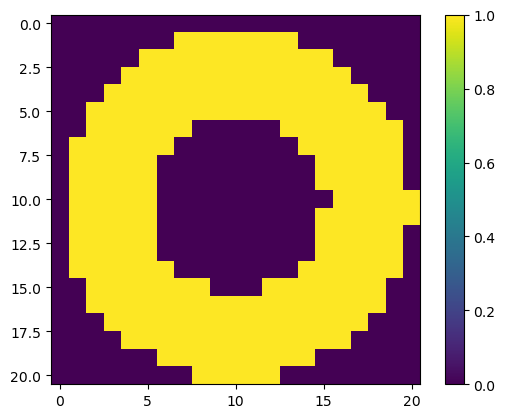

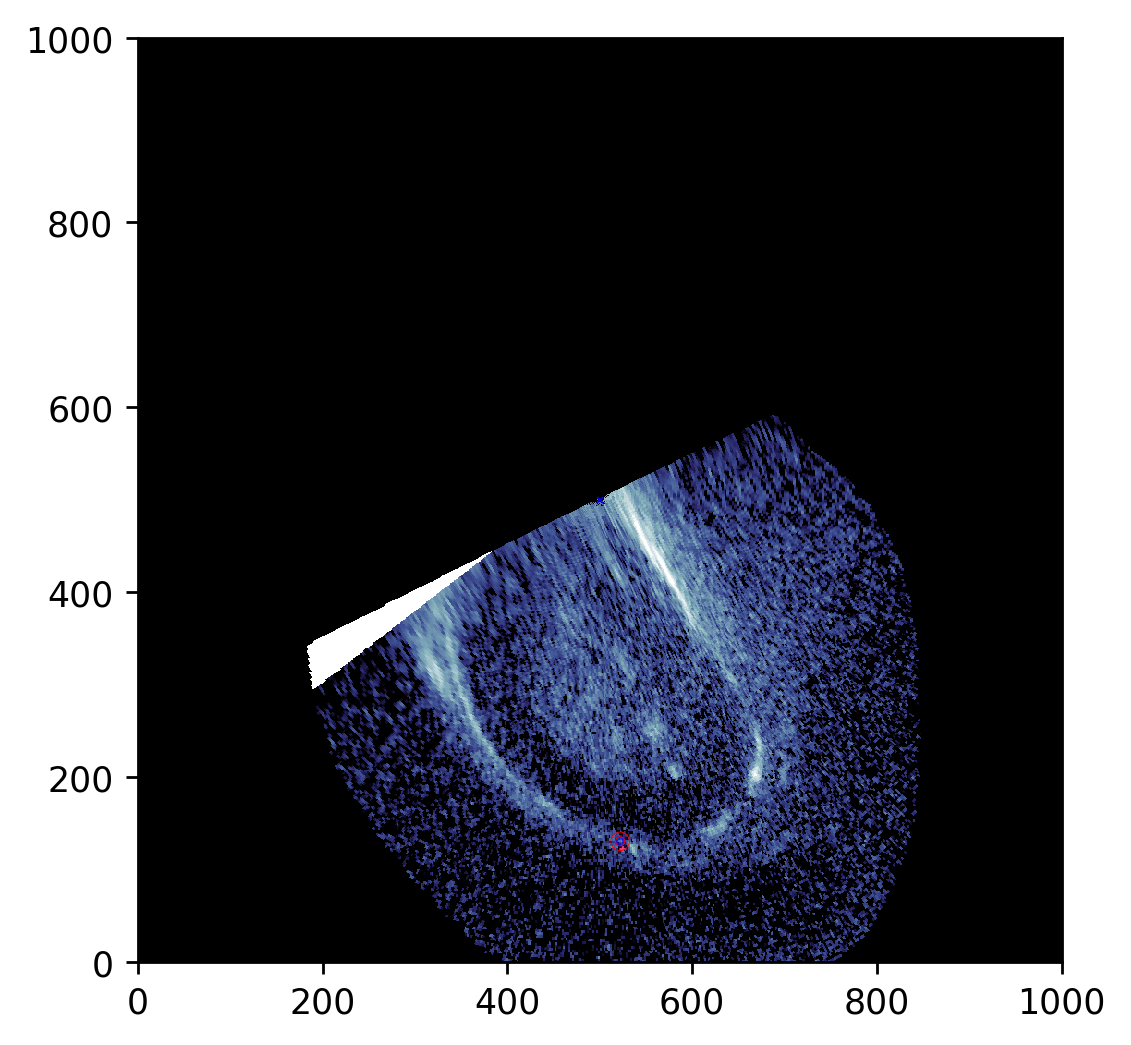

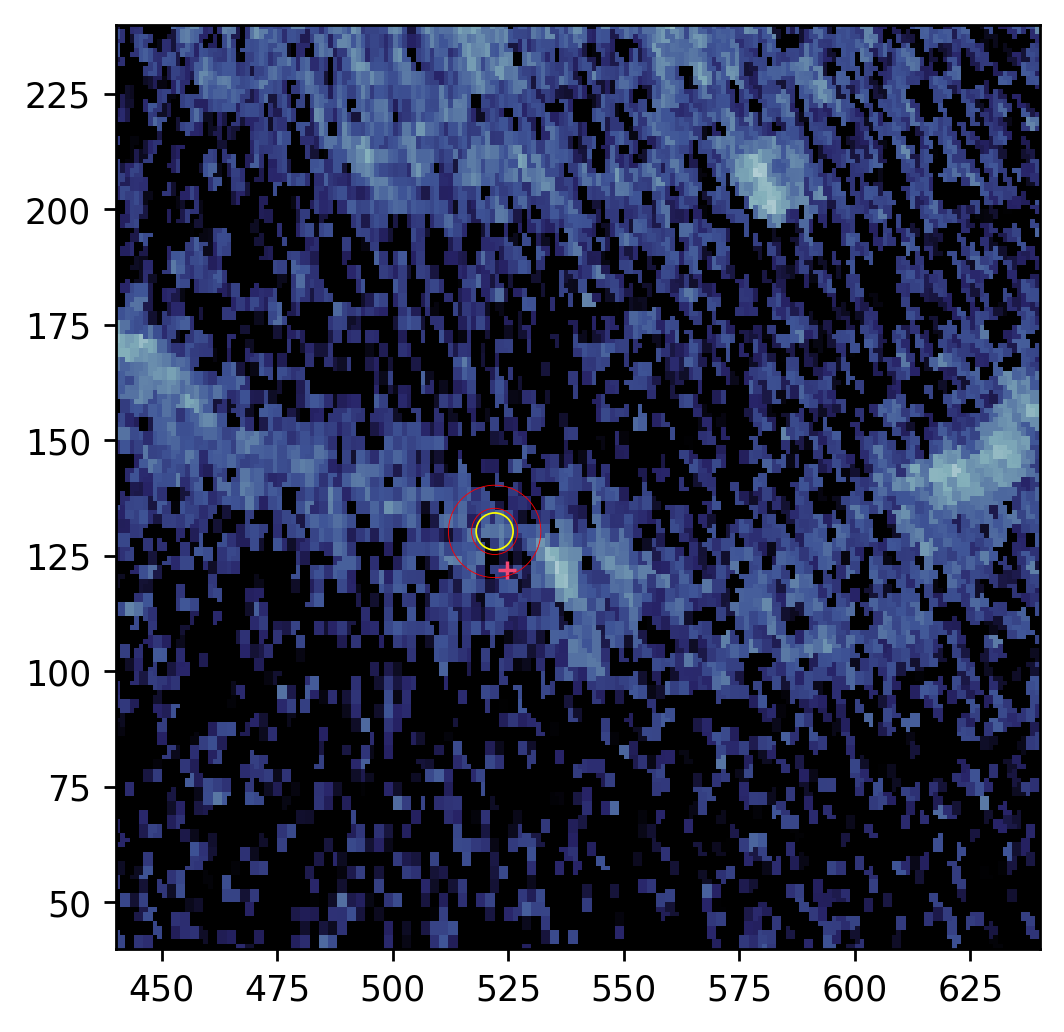

In [291]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  # [px]
positions[:,0] += x0    # [px]
positions[:,1] += y0    # [px]

posarg0 = np.argmin(np.absolute((positions[:,0]-ftpX)**2 + (positions[:,1]-ftpY)**2))
print('=== The spot ===')
print('Nearest [px]:', posarg0, positions[posarg0,:])
print('Number of pixels [px]: ', sources['npix'][posarg0])
print('Brightness peak [kR]: ', sources['peak'][posarg0])
print('Brightness flux [kR]: ', sources['flux'][posarg0]*thres)

posX = positions[posarg0,0]-Npx/2
posY = positions[posarg0,1]-Npx/2
posR = math.sqrt(posX**2 + posY**2)             # [px]
poslat = posR*(2*extdeg/Npx)
poslat = math.degrees(2*math.atan2(posR*math.tan(0.5*math.radians(90-extdeg)), Npx/2))
postheta = math.atan2(posY,posX)-0.5*np.pi
# print('theta [deg]', math.degrees(postheta))
print('Wlong [deg]', -math.degrees(postheta))
print('Lat [deg]', 90-poslat)

# Aperture photometry
apertures = CircularAperture(positions[posarg0,:], r=4.)
rawflux = aperture_photometry(dimage, apertures)
# print(rawflux)

# 局所的な背景を測定する
# 各スポットを中心とした輪っかを作成
annulus_apertures = CircularAnnulus(positions[posarg0,:], r_in=5., r_out=10.)

# sigmaクリッピング法を用いる
# http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
annulus_masks = annulus_apertures.to_mask(method='center')
annulus_data = annulus_masks.multiply(dimage)
annulus_data_1d = annulus_data[annulus_masks.data > 0]
_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
bkg_median = median_sigclip
rawflux['annulus_median'] = bkg_median
rawflux['aper_bkg'] = bkg_median*apertures.area
rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
print(rawflux['final_phot'])
plt.imshow(annulus_masks)
plt.colorbar()
plt.show()



# Plots
fig, ax = plt.subplots(dpi=250)
ax.set_aspect('equal')
# ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(), vmin=median-5*std, vmax=median+5*std, zorder=0.1)
ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.plot(ftpX, ftpY,
        markersize=2, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=0.5, zorder=1)
ax.plot(Npx/2, Npx/2,
        markersize=2, marker='x', markerfacecolor='blue',
        markeredgecolor='blue', markeredgewidth=0.5, zorder=1)
apertures.plot(color='blue', lw=1.0, alpha=0.6)
annulus_apertures.plot(color='red', lw=0.25)
plt.show()

fig, ax = plt.subplots(dpi=250)
ax.set_aspect('equal')
ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)
# ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(), vmin=median-5*std, vmax=median+5*std, zorder=0.1)
ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.plot(ftpX, ftpY,
        markersize=5, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=1, zorder=1)
ax.plot(Npx/2, Npx/2,
        markersize=2, marker='x', markerfacecolor='blue',
        markeredgecolor='blue', markeredgewidth=0.5, zorder=1)
apertures.plot(color='yellow', lw=0.5, alpha=1.0)
annulus_apertures.plot(color='red', lw=0.25, alpha=1.0)
plt.show()

In [292]:
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])
eqs3wlon = ftpS3.ftpS3().S3(180, satoval, 'EUROPA')
print(eqs3wlon)

AttributeError: 'ftpS3' object has no attribute 'S3'

In [ ]:
eqs3wlon = ftpS3.ftpS3().S3(7, satoval, 'EUROPA')
print(eqs3wlon)

AttributeError: 'ftpS3' object has no attribute 'S3'